In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os,fnmatch
import seaborn as sns ; sns.set()
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2 
%matplotlib inline
print(tf.__version__)

2.2.0-rc3


In [0]:
!wget http://peipa.essex.ac.uk/pix/mias/all-mias.tar.gz

In [0]:
!wget https://mynotebook.labarchives.com/attachments/My45MDAwMDAwMDAwMDAwMDA0fDg1NzYyLzMvRW50cnlQYXJ0LzQxNTk4ODc0Nzh8OS44OTk5OTk5OTk5OTk5OTk=/1/original?sf324=343


In [0]:
!mkdir Images
!tar -C Images -zxvf all-mias.tar.gz

In [0]:
#optional (first time)
def load_data():
    
    files = os.listdir("Images")
    files.remove("Info.txt")
    files.remove("Licence.txt")
    files.remove("README")
    
    os.mkdir("Images/train")
    os.mkdir("Images/test")

    for i in range(len(files)):
      x = cv2.imread("Images/"+files[i])
      if(i<round(0.6*len(files))):
        cv2.imwrite("Images/train/"+str(i)+".png",x)
      else:
          
        cv2.imwrite("Images/test/"+str(i)+".png",x)

    

load_data()

In [0]:
class DataGen:
    def __init__(self,path,batch_size,target_size):
        self.path = path
        self.batch_size = batch_size
        self.target_size = target_size
        
    def getImage(self,imPath):
        img = cv2.imread(imPath,0)
        return img
    
    def rescale(self,img):
        x = img/255.0
        return x
    
    def resize(self,img):
        x = cv2.resize(img,self.target_size,interpolation=cv2.INTER_CUBIC)
        x = np.reshape(x,(64,64,1))
        return x
    
    def addNoise(self,img,noise_factor,mu=0,sigma=1):
        
        
        img+= noise_factor*np.random.normal(mu,sigma,size=img.shape) 

        img = np.clip(img,0.,1.)
        return img
    def poisson_noise(self,img):
      
        img+= numpy.random.poisson(img).astype(float)
        img = np.clip(img,0.,1.)
        return img


    def generate(self):
        import os
        
        files = os.listdir(self.path)
        while(True):
            batch_paths  = np.random.choice(a    = files, 
                                          size = self.batch_size)
            batch_input  = []
            batch_output = [] 
          
          # Read in each input, perform preprocessing and get labels
            for input_path in batch_paths:
                img = self.getImage(self.path+input_path)
                img = self.rescale(img)
                img = img.astype(np.float)
                output = self.resize(img)
                img = self.addNoise(img,0.1) # second argument is p  in paper for gaussian noise
                img = self.resize(img)
                batch_input += [ img ]
                batch_output += [ output ]
          # Return a tuple of (input, output) to feed the network
            batch_x = np.array( batch_input )
            batch_y = np.array( batch_output )
        
            yield batch_x, batch_y
        

In [0]:
# (Important) split all images in folder "Images" in 60-40 percent as 60% images in "Images/train" folder and 40% in "Images/test" folder 
train = DataGen("Images/train/",16,(64,64)) 

In [0]:
train_gen = train.generate() # training set generator

In [0]:
test = DataGen("Images/test/",10,(64,64))

In [0]:
test_gen = test.generate() # test set generator

In [0]:
class callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('loss')<0.23 and logs.get('val_loss')<0.23:
            print("\n Stopping training .....\n")
            self.model.stop_training=True
            

In [0]:
myCallback = callback() 

In [0]:
autoencoder = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64,(3,3),input_shape=(64,64,1),activation="relu",padding="same",data_format="channels_last"),

    tf.keras.layers.MaxPool2D(padding="same"),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"),

    tf.keras.layers.MaxPool2D(padding="same"),

    tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"),

    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu",padding="same"),

    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(1,(3,3),activation="sigmoid",padding="same")
    
    
  ])

In [59]:
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 64)       

In [0]:
autoencoder.compile(optimizer='adam', loss="binary_crossentropy",metrics = ['accuracy'])

In [61]:
# let it run upto 10 epochs
hist = autoencoder.fit_generator(train_gen,epochs=10,steps_per_epoch=16,validation_data=test_gen,validation_steps=10,callbacks=[myCallback])


Epoch 1/10
16/16 [==============================] - 23s 1s/step - loss: 0.4905 - accuracy: 0.4553 - val_loss: 0.2854 - val_accuracy: 0.4732
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 0.2888 - accuracy: 0.4679 - val_loss: 0.2671 - val_accuracy: 0.4888
Epoch 3/10
16/16 [==============================] - 23s 1s/step - loss: 0.2733 - accuracy: 0.4781 - val_loss: 0.2650 - val_accuracy: 0.4811
Epoch 4/10
16/16 [==============================] - 23s 1s/step - loss: 0.2668 - accuracy: 0.4652 - val_loss: 0.2597 - val_accuracy: 0.4722
Epoch 5/10
16/16 [==============================] - 23s 1s/step - loss: 0.2675 - accuracy: 0.4589 - val_loss: 0.2573 - val_accuracy: 0.4775
Epoch 6/10
16/16 [==============================] - 23s 1s/step - loss: 0.2569 - accuracy: 0.4765 - val_loss: 0.2497 - val_accuracy: 0.4869
Epoch 7/10
16/16 [==============================] - 23s 1s/step - loss: 0.2567 - accuracy: 0.4690 - val_loss: 0.2439 - val_accuracy: 0.4893
Epoch 8/10
16/16 [==

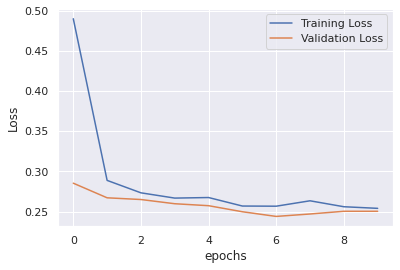

In [62]:
plt.ylabel("Loss")
plt.xlabel("epochs")

plt.plot(hist.history["loss"],label="Training Loss")
plt.plot(hist.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

In [0]:
from mpl_toolkits.axes_grid1 import ImageGrid


In [0]:
r,t = next(test_gen) # sample

In [0]:
z = autoencoder.predict(r) # predicted result

In [76]:
# prediction batch
z.shape

(10, 64, 64, 1)

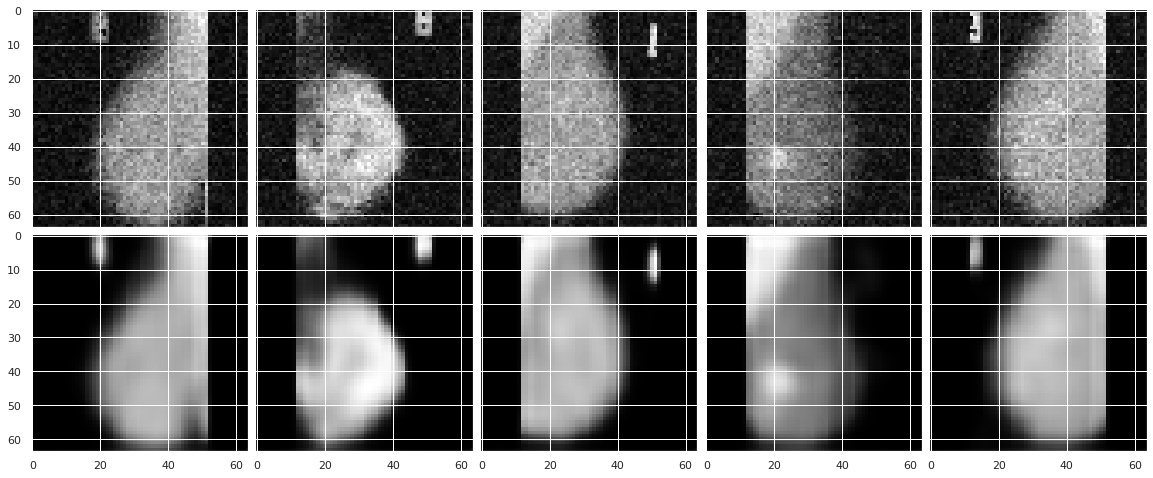

In [77]:
img1 = r[0][:,:,0]
img2 = r[1][:,:,0]
img3 = r[2][:,:,0]
img4 = r[3][:,:,0]
img5 = r[4][:,:,0]

den_img1 = z[0][:,:,0]*255.
den_img2 = z[1][:,:,0]*255.
den_img3 = z[2][:,:,0]*255.
den_img4 = z[3][:,:,0]*255.
den_img5 = z[4][:,:,0]*255.


fig = plt.figure(figsize=(20., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 5),  # creates 2x5 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [img1,img2,img3,img4,img5,den_img1,den_img2,den_img3,den_img4,den_img5]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap="gray")

plt.show()

In [78]:
from skimage.measure import compare_ssim as ssim

def get_ssim_result(originalSet,noisySet):
    ssim_sum = 0
    originalSet = originalSet.reshape(originalSet.shape[0],64, 64, 1)
    noisySet = noisySet.reshape(noisySet.shape[0],64, 64, 1)
    for i in range(originalSet.shape[0]):
        ssim_sum += ssim(originalSet[i], noisySet[i],data_range=originalSet[i].max() - noisySet[i].min(), multichannel=True)
    return 1.0*ssim_sum/originalSet.shape[0]
get_ssim_result(r, z)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  


0.38199042512207143